# TP 2: segmentation and classification of PreTest signals
Topics:
-  Noisy labels
-  Imbalanced dataset
-  Feature extraction
-  Dimension reduction

In [210]:
%load_ext autoreload
%autoreload 2
from data_exploration import get_data, prepare_data, prepare_augmented_dataset, get_dataset_balance
import matplotlib.pyplot as plt
import numpy as np
from data_analyzis import get_pressure_pca, plot_pressure_pca, plot_gmm_fit_pca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
data = get_data()
pressure, labels = prepare_data(data)

['station_reference', 'drawdown_start_idx', 'drawdown_end_idx', 'buildup_start_idx', 'buildup_end_idx', 'drawdown_volume', 'drawdown_pressure', 'buildup_volume', 'buildup_pressure', 'buildup_label']


In [ ]:
plt.figure(figsize=(10,10))
for press, label in zip(pressure, labels):
    plt.plot(press, "g-" if label==1 else "r-", alpha=0.1)
plt.xlabel("Normalized temporal index")
plt.ylabel("Normalized pressure measurements")
plt.title("Labelled Normalized pressure measurements for all runs\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

# Preliminary data analyzis

In [ ]:
plt.figure(figsize=(10,10))
for press, label in zip(pressure, labels):
    plt.plot(press - np.linspace(0, 1, len(press)), "g-" if label==1 else "r-", alpha=0.1)
plt.xlabel("Normalized temporal index")
plt.ylabel("Normalized pressure measurements")
plt.title("Pressure measurements after major trend removal\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
pos, neg = [], []
for press, label in zip(pressure, labels):
    max_feature = np.max(press - np.linspace(0, 1, len(press)))
    if label == 1:
        pos.append(max_feature)
    else:
        neg.append(max_feature)
plt.hist(pos, bins=30, alpha=0.5, label="Normal", color="green")
plt.hist(neg, bins=30, alpha=0.5, label="Faulty", color="red")
plt.title("Histogram of an handcrafted feature: Max on pressure profile after trend removal\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

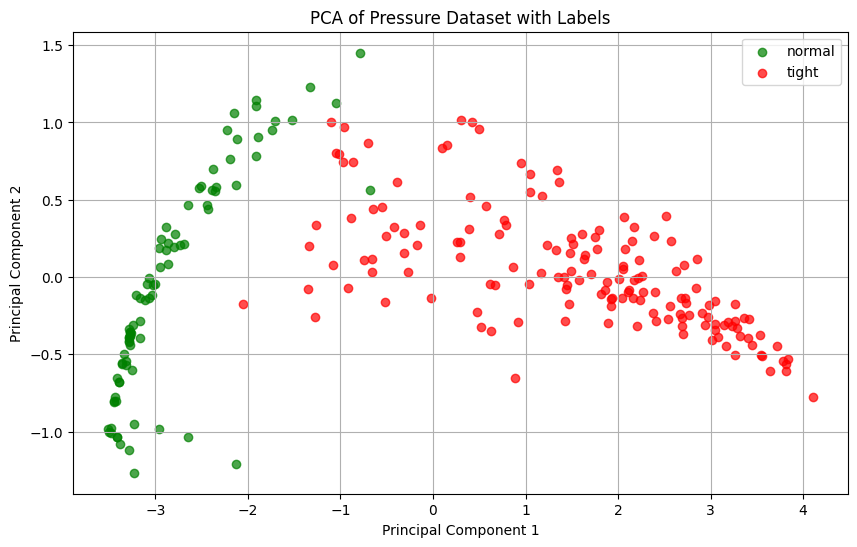

In [196]:
pressure_pca, pca = get_pressure_pca(pressure)
plot_pressure_pca(pressure_pca, labels)

In [ ]:
plot_gmm_fit_pca(pressure, pressure_pca, labels, pca)

# Imbalanced dataset

In [208]:
get_dataset_balance(labels, desc="Original dataset")

Original dataset Total normal samples: 85 = 35.1%
Original dataset Total tight samples: 157 = 64.9%


In [218]:
ratio_tight = 0.4
noisy_label_ratio = 0.2
# pressure_imb, labels_imb = force_dataset_imbalance(pressure, labels, ratio_tight=0.4)
pressure_imb, labels_imb = prepare_augmented_dataset(pressure, labels, ratio_tight=ratio_tight, ratio_noisy_label=noisy_label_ratio)
get_dataset_balance(labels_imb, desc=f"Forced imbalance {ratio_tight:.0%}")

Forced imbalance 40% Total normal samples: 107 = 60.1%
Forced imbalance 40% Total tight samples: 71 = 39.9%


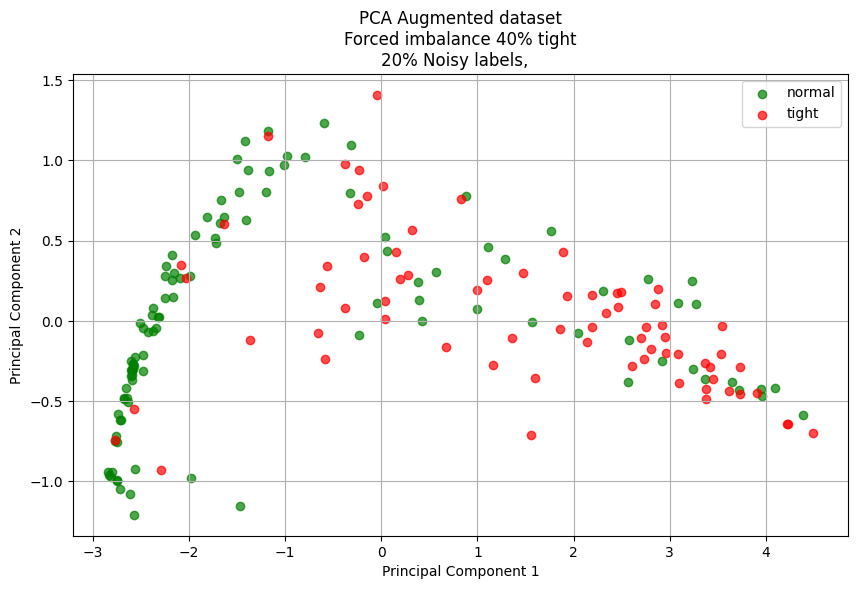

In [220]:
pressure_pca, pca = get_pressure_pca(pressure_imb)
plot_pressure_pca(pressure_pca, labels_imb, desc=f"Augmented dataset\nForced imbalance {ratio_tight:.0%} tight\n{noisy_label_ratio:.0%} Noisy labels,  ")